# Downloading deforestation map data from the Global Forest Change 2000-2018 dataset

This will test downloads of map data from the [Global Forest Change 2000-2018](https://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.6.html) dataset. This dataset includes various layers of information derived from satellite images, mainly from Landsat, related to forests cover loss and gain over the past two decades. A complete visualization of this data can be accessed [here](https://earthenginepartners.appspot.com/science-2013-global-forest).

In [1]:
import numpy as np
import yaml
import requests
import urllib
import imageio
from pathlib import Path
from skimage.transform import resize
import matplotlib.pyplot as plt
import PIL
from PIL import ImageEnhance
%matplotlib inline

The data has been divided into 10x10 degree granules encompassing the entire globe. The resolution is of 1 arc-second per pixel (approximately 30 meters per pixel at the equator).

Each granule has been divided into 6 layers with the following information in each (information from [University of Maryland](https://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.6.html)):

 * `treecover2000`: Tree canopy cover for year 2000, defined as canopy closure for all vegetation taller than 5m in height. Encoded as a percentage per output grid cell, in the range 0–100.
 * `gain`: Global forest cover gain 2000–2012. Forest gain during the period 2000–2012, defined as the inverse of loss, or a non-forest to forest change entirely within the study period. Encoded as either 1 (gain) or 0 (no gain).
 * `lossyear`: Year of gross forest cover loss event. Forest loss during the period 2000–2018, defined as a stand-replacement disturbance, or a change from a forest to non-forest state. Encoded as either 0 (no loss) or else a value in the range 1–17, representing loss detected primarily in the year 2001–2018, respectively.
 * `datamask`: Data mask Three values representing areas of no data (0), mapped land surface (1), and permanent water bodies (2).
 * `first`: Circa year 2000 Landsat 7 cloud-free image composite. Reference multispectral imagery from the first available year, typically 2000. If no cloud-free observations were available for year 2000, imagery was taken from the closest year with cloud-free data, within the range 1999–2012.
 * `last`: Circa year 2018 Landsat cloud-free image composite. Reference multispectral imagery from the last available year, typically 2018. If no cloud-free observations were available for year 2018, imagery was taken from the closest year with cloud-free data, within the range 2010–2015.

We have a YAML file with the download links for each layer and granule. We can load it as a dict of lists of strings.

In [2]:
data_folder = Path("../data/")

with open(data_folder/"hansen_urls.yaml") as yaml_file:
    urls = yaml.load(yaml_file, Loader=yaml.FullLoader)

layer_names = list(urls.keys())

Before anythong else, it would be useful to have a function that translates a pair of latitude/longitude coordinates into the string code for the corresponding granule that contains said point. The granules are identified by the value of their top-left (NW) corner, in degrees. They do not include the poles, and only go from 60 degrees South to 80 degrees North.

In [3]:
def coords_to_granule(coords):
    lat, lon = coords
    assert -90 <= lat <= 90, "Longitude out of valid range"
    assert -180 <= lon < 180, "Latitude out of valid range"
    
    # Transform the latitude
    granule_lat = int(np.ceil(lat/10)*10)
    str_lat = str(abs(granule_lat)).zfill(2) + ("N" if granule_lat >= 0 else "S")
    
    # Transform the longitude
    granule_lon = int(np.floor(lon/10)*10)
    str_lon = str(abs(granule_lon)).zfill(3) + ("E" if granule_lon >= 0 else "W")
    
    return str_lat + "_" + str_lon

In [4]:
coords_to_granule((40.416775, -3.703790))  # Madrid!

'50N_010W'

We can also easily have a function that takes a pair of coordinates and a layer name and retrieves the appropriate url from the dict we created before.

In [5]:
def url_for_granule(coords, layer, url_dict=urls):
    assert -60 < coords[0] <= 80, "Longitude out of available granule range"
    assert layer in url_dict, "Requested layer is not in the provided URL dict"
    for url in url_dict[layer]:
        granule_str = coords_to_granule(coords)
        if granule_str in url:
            return url
    raise Exception(f"URL not found for granule {granule_str} corresponding to requested coordinates {coords}.")

In [6]:
url_for_granule((40.416775, -3.703790), "gain")

'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2018-v1.6/Hansen_GFC-2018-v1.6_gain_50N_010W.tif'

Next, we will create a function to download the TIFF file from one of these URLS.

In [7]:
def download_granule(coords, layer, destination, url_dict=urls, redownload=False):
    url = url_for_granule(coords, layer, url_dict=urls)
    filename = Path(urllib.parse.urlparse(url).path).name
    destination = Path(destination)
    # If file already exists, do not download again unless specified
    if ((destination/filename).is_file() == False) or redownload:
        request = requests.get(url, allow_redirects=True)
        with open(destination/filename, 'wb') as file:
            file.write(request.content)

In [10]:
download_granule((40.416775, 23), layer="treecover2000", destination=data_folder/"hansen/")

In [36]:
# If the file has not been downloaded already, this will take a while!
download_granule((40.416775, -3.703790), layer="treecover2000", destination=data_folder/"hansen/")

Great! Now we can easily retrieve data from whatever area of the globe we want. Let's take a look at the granule we just downloaded. The image is so bin that we are going to have to increase the limit of what PIL is allowed to try to open.

In [13]:
PIL.Image.MAX_IMAGE_PIXELS = 2000000000

In [37]:
granule = PIL.Image.open(data_folder/"hansen/Hansen_GFC-2018-v1.6_treecover2000_50N_010W.tif")
granule.size

(40000, 40000)

Wow, that is a 40k x 40k pixel image, so 1600 million pixels overall. We might or might not end up working with the full data, but let's reduce its size for visualization purposes now.

In [21]:
# Using skimage.transform.resize
granule_resized = granule.resize((400, 400), PIL.Image.ANTIALIAS)

And finally we can take a look at the image!

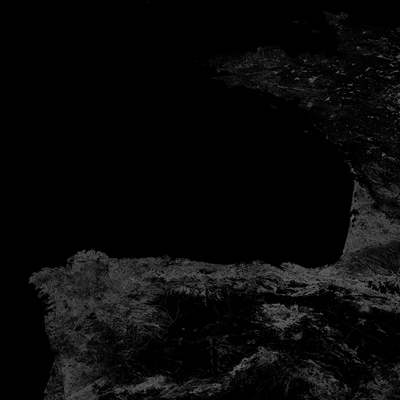

In [25]:
granule_resized

It represents the land covered by trees in the year 2000 in the northern part of Spain. The image is grey and quite dim. This is because it has a single channel, in which values from 0 to 100 representing percentage of land covered by trees in that section are being interpreted as a brightness value from 0 to 255. We rescale the values by 255/100 in order to improve the visualization.

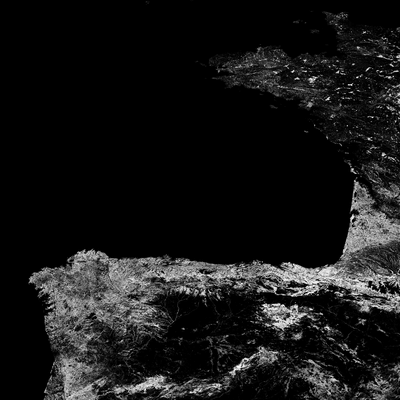

In [33]:
ImageEnhance.Brightness(granule_resized).enhance(255/100)

We should also have a function for downloading the corresponding granules to a list of coordinates.

In [40]:
def download_list(coords_list, layer, destination, url_dict=urls):
    for coords in coords_list:
        print(f"Downloading data for layer {layer} at coordinates {coords}...")
        try:
            download_granule(coords, layer=layer, destination=destination, url_dict=urls, redownload=False)
            print(f"Complete!")
        except:
            print(f"Download failed! D:")
    print(f"Finished download queue :D")

In [45]:
all_granules = [(lat, lon) for lon in range(-180, 180, 10) for lat in range(-50, 90, 10)]
print(len(all_granules))

504


In [ ]:
%%time
destination = "/Users/miguel/Documents/hansen"
layer = "treecover2000"

download_list(all_granules[10:100], layer=layer, destination=destination)

Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
